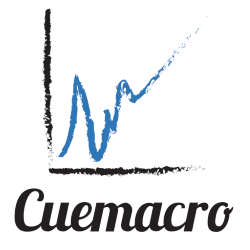

# Additional benchmarks and metrics for tcapy

**Saeed Amen / Founder of Cuemacro**

https://www.cuemacro.com / saeed@cuemacro.com / @saeedamenfx / All material is copyright Cuemacro / 2020

In this notebook we discuss some of the additional benchmarks and metrics which are available in tcapy. You can also create your own benchmarks and metrics with tcapy. Before going through this notebook, we recommend first reading through other notebooks available for tcapy [here](https://github.com/cuemacro/tcapy/blob/master/tcapy_notebooks/jupyter_notebooks_description.md) in particular the introduction.

## Benchmarks

Here we'll go through some of the benchmarks available in tcapy, which can be used for trades/orders (although some are more appropriate for orders). The abstract class `Benchmark` in tcapy can be extended to create your own customised benchmarks. Some which extend `BenchmarkMarket` are calculated purely on market data to provide more granularity over the market. However, there are many which extend `BenchmarkTrade` which can be used to calculate specific benchmarks for trades/orders.

* Arrival price (`BenchmarkArrival`) - 
    * arrival price at start of order/trade fill
* TWAP (`BenchmarkTWAP`) 
    * time weighted average price over the order window
* VWAP (`BenchmarkVWAP`) - 
    * volume weighted average price over the order window
* Best price (`BenchmarkBest`) 
    * best price over the order over the order window, ie. the minimum price for buys and maximum price for sells
* Worst price (`BenchmarkWorst`) 
    * worst price over the order over the order window, ie. the maximum price for buys and minimum price for sells, if we repeatedly get filled at the worst price in our window, it is worth investigating why and talk to our liquidity providers
* Median price (`BenchmarkMedian`)
    * median price over the order window

We can also select parameters to start the window earlier before our trade/order and finish later. This enables us to create a window for trades, which are points-in-time (unlike orders which already have a start and finish times). We can also assign a specific time of day as a benchmark. Hence for example, we could benchmark our trades/orders against:

* A TWAP calculated on the window between 15:59:30 - 16:00:30 (London time) on the same day as a trade/order window as a proxy for the WMR fix (note, for Sunday evening FX trades the benchmark would be last tick of Friday)
* Arrival/mid price at 16:00:00

We later show how to do these benchmarks when calculating the slippage metric. Slippage is simply the difference between the execution price and the benchmark. If it is negative, it implies you executed worse than the benchmark, whilst positive numbers indicate you've executed better than the benchmark.

## Importing and setting up source for tcapy

Our first step is to add the tcapy library to our `PYTHONPATH`. You may need to change these lines. Note, that in our setup, we are running the Jupyter notebook on Windows, and the backend Celery workers on Linux. If you are running everything in the same environment, the paths are likely to be same.

In [1]:
import sys
import os

windows_tcapy_path = 'e:/cuemacro/tcapy' # Windows platform
linux_tcapy_path = '/home/tcapyuser/cuemacro/tcapy' # Linux platform
local_test_data_path = '../test/resources/' # Windows platform
remote_test_data_path = '../test/resources/' # WSL drive

# Assuming the front end is on Windows
sys.path.insert(0, windows_tcapy_path)

If the Python path now includes tcapy, we can do all the imports from it, that we'll need later. We'll also import all the other Python libraries we'll use.

In [2]:
from collections import OrderedDict

# This is the entry point for our TCA analysis
from tcapy.analysis.tcaengine import TCAEngineImpl

# To construct the parameters for our TCA calculation
from tcapy.analysis.tcarequest import TCARequest

# To access trade and market data
from tcapy.data.databasesource import DatabaseSourceCSVBinary, \
    DatabaseSourceDataFrame, DatabaseSourceDukascopy

# Import all the metrics and benchmarks we'll use
from tcapy.analysis.algos.benchmark import *
from tcapy.analysis.algos.metric import *

# To aggregate the TCA results
from tcapy.analysis.algos.resultsform import TimelineResultsForm, DistResultsForm, BarResultsForm

# To help display the output of a TCA calculation
from tcapy.vis.tcaresults import TCAResults
from tcapy.vis.report.tcareport import TCAReport
from tcapy.vis.displaylisteners import PlotRender

# General classes
from tcapy.conf.constants import Constants
from tcapy.util.mediator import Mediator

# Prevent requests from displaying debug messages for certain libraries
import logging

logging.getLogger("findatapy").setLevel(logging.WARNING)
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

# For plotting later
import plotly.io as pio

# For interactive plots (but these disappear when we reopen Jupyter)
pio.renderers.default = "notebook" 

# Using https://github.com/plotly/Kaleido to generate static plot images
# pio.renderers.default = "svg"
pio.renderers.default = "png" 

import plotly

from chartpy import Chart, Style

# Default size for Plotly charts we use
chart_width = 800
chart_height = 500

chart = Chart()
constants = Constants()
style = Style(width=chart_width, height=chart_height, scale_factor=-1, silent_display=True)

# Entry point for TCA calculations
tca_engine = TCAEngineImpl(version=constants.tcapy_version)

2020-07-27 12:30:56,255; INFO:tcapy.analysis.tcaengine: Init TCAEngine version: pro - Env: desktop_laptop_linux (tcaengine.py:53)


We'll now create a mapping so tcapy knows where the CSV files for our trade/orders. These test files come with tcapy.

In [3]:
# The test trade/order data is populated between 25 Apr 2017-05 Jun 2017
# with trades/orders for 'EURUSD', 'USDJPY' and 'EURJPY'
local_csv_trade_order_mapping = OrderedDict([('trade_df', os.path.join(local_test_data_path, 'small_test_trade_df.csv')),
                                             ('order_df', os.path.join(local_test_data_path, 'small_test_order_df.csv'))])

remote_csv_trade_order_mapping = OrderedDict([('trade_df', os.path.join(remote_test_data_path, 'small_test_trade_df.csv')),
                                              ('order_df', os.path.join(remote_test_data_path, 'small_test_order_df.csv'))])

### Calculating slippage with 1600 LDN vs mid (arrival) price benchmark

In this case, we create a benchmark price at 1600 LDN to proxy WMR, calculating a TWAP between 15:58:00 - 16:00:30, which can be used to benchmark all trades that day. We then use this value to calculate the slippage. We'll also use a mid price (and arrival price, although this is essentially the same thing) as other benchmarks.

In [4]:
benchmark_calcs = [
    # Calculate mid as a benchmark
    BenchmarkMarketMid(),
    
    # Calculate TWAP around 1600 LDN as a benchmark for every trade/order
    BenchmarkTWAP(start_time_before_offset={'m' : 2}, 
        finish_time_after_offset={'s' : 30},
        overwrite_time_of_day='16:00', 
        overwrite_timezone='Europe/London',
        benchmark_post_fix="1600LDN"), 
    
    # Calculate arrival of mid price for every trade/order
    BenchmarkArrival()]

We'll calculate slippage using two benchmarks 1600 LDN TWAP and the mid price at time of trade/order (the same as the arrival price).

In [5]:
metric_calcs = [MetricSlippage(bid_benchmark='twap1600LDN', ask_benchmark='twap1600LDN', metric_post_fix='twap1600LDN'),
               MetricSlippage(bid_benchmark='mid', ask_benchmark='mid', metric_post_fix='mid')]

We want to calculate a timeline of these two slippage metrics, calculated with these two respective benchmarks. Note, that we multiply the `scalar` by `10000.0` given that we want to convert the results into basis points.

In [6]:
results_form=[TimelineResultsForm(metric_name='slippagetwap1600LDN', scalar=10000.0),
              TimelineResultsForm(metric_name='slippagemid', scalar=10000.0)]

Let's wrap this calculation up in a `TCARequest`. Here we specify the dates, ticker and other parameters, alongside all the `metric_calcs`, `results_form` and `benchmark_calcs`. For simplicity we are not using multithreading here and we are downloading the data directly from Dukascopy over the web, so not using any database for market data.

In [7]:
# We are conducting a TCA computation for trade/order data between 07 May-15 May 2017 for EURUSD
# The trade dataset is from CSV and the market data is downloaded from Dukascopy on the fly
tca_request = TCARequest(start_date='07 May 2017', finish_date='15 May 2017', ticker=['EURUSD'],
                         tca_type='detailed',
                         trade_data_store='csv', market_data_store='dukascopy',
                         trade_order_mapping=local_csv_trade_order_mapping,
                         metric_calcs=metric_calcs,
                         results_form=results_form,
                         benchmark_calcs=benchmark_calcs,
                         extra_lines_to_plot='twap1600LDN',
                         use_multithreading=False)

Let's kick off the TCA calculation, on our trade/order data, with market data from Dukascopy.

In [8]:
# Dictionary of (mostly) dataframes as output from TCA calculation
dict_of_df = tca_engine.calculate_tca(tca_request)

2020-07-27 12:30:56,319; DEBUG:tcapy.analysis.tcamarkettradeloader: Start loading trade/data/computation (tcamarkettradeloader.py:241)
2020-07-27 12:30:56,322; DEBUG:tcapy.analysis.tcatickerloaderimpl: Get market and trade/order data for EURUSD from 2017-05-07 00:00:00+00:00 - 2017-05-15 00:00:00+00:00 (tcatickerloaderimpl.py:80)
2020-07-27 12:30:56,324; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['dukascopy_EURUSD_2017-05-07 00:00:00+00:00_2017-05-15 00:00:00+00:00_market_df_None_comp'] (volatilecache.py:540)
2020-07-27 12:30:56,334; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['dukascopy_EURUSD_2017-05-07 00:00:00+00:00_2017-05-15 00:00:00+00:00_market_df_None_comp'] (volatilecache.py:540)
2020-07-27 12:30:56,509; DEBUG:tcapy.data.databasesource: Downloading 2017-05-07 00:00:00 - 2017-05-15 00:00:00 for EURUSD (databasesource.py:3819)
2020-07-27 12:31:09,655; WARNING:tcapy.analysis.algos.benchmark: mid not in market data (benchmark.py:90

We get back a bunch of DataFrames (and candlestick Plotly Figure) etc. from our calculations, which we display below.

In [9]:
dict_of_df.keys()

odict_keys(['trade_df', 'order_df', 'sparse_market_trade_df', 'sparse_market_order_df', 'market_df_downsampled', 'candlestick_fig', 'timeline_trade_df_slippagetwap1600LDN_by/mean_date/all', 'timeline_trade_df_slippagemid_by/mean_date/all', 'timeline_order_df_slippagetwap1600LDN_by/mean_date/all', 'timeline_order_df_slippagemid_by/mean_date/all', 'market_df'])

If we display the first few trades, we note all the additional calculated fields to the right of the table, such as `twap1600LDN`, `arrival`, `slippagetwap1600LDN` etc.

In [10]:
dict_of_df['trade_df'].head(3)

,account_id,algo_id,algo_settings,ancestor_pointer_id,broker_id,broker_sub_id,event_type,executed_notional,executed_price,id,...,reporting_currency,executed_notional_in_reporting_currency,order_notional_in_reporting_currency,notional,twap1600LDN,arrival,slippagetwap1600LDN_benchmark,slippagetwap1600LDN,slippagemid_benchmark,slippagemid
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-08 10:31:33.011000+00:00,account1,algo3,default,order_EURUSD2017-05-08 10:30:57.526000+00:00_2...,broker4,subbroker2,trade,3276653,1.094703,execution_EURUSD2017-05-08 10:31:33.011000+00:...,...,USD,3.586887e+06,3.586887e+06,3276653,1.093353,1.09468,1.093353,-0.001235,1.09468,-0.000021
2017-05-08 14:37:25.382000+00:00,account5,algo1,default,order_EURUSD2017-05-08 14:36:43.422000+00:00_2...,broker3,subbroker5,trade,14184843,1.093766,execution_EURUSD2017-05-08 14:37:25.382000+00:...,...,USD,1.551467e+07,1.551467e+07,14184843,1.093353,1.09375,1.093353,-0.000378,1.09375,-0.000015
2017-05-09 06:56:00.013000+00:00,account4,algo5,default,order_EURUSD2017-05-09 06:55:28.484000+00:00_2...,broker6,subbroker3,trade,6852731,1.090660,execution_EURUSD2017-05-09 06:56:00.013000+00:...,...,USD,7.473932e+06,7.473932e+06,6852731,1.089211,1.09065,1.089211,-0.001330,1.09065,-0.000009


If we create a `TCAResults` object, we can render lots of nice charts from our TCA output. It also organises the various DataFrames in an easier to access way.

In [11]:
tca_results = TCAResults(dict_of_df, tca_request, chart_width=chart_width, chart_height=chart_height)
tca_results.render_computation_charts()

2020-07-27 12:31:11,165; DEBUG:tcapy.vis.displaylisteners: Plotting main timeline 2840 (displaylisteners.py:988)
2020-07-27 12:31:11,230; DEBUG:tcapy.vis.displaylisteners: Rendered plot 2840 and  (displaylisteners.py:998)
2020-07-27 12:31:11,233; DEBUG:tcapy.vis.displaylisteners: Plotting main timeline 2840 (displaylisteners.py:988)
2020-07-27 12:31:11,296; DEBUG:tcapy.vis.displaylisteners: Rendered plot 2840 and  (displaylisteners.py:998)


Let's take a look at the timeline DataFrame objects which have been output. In this instance, these are time series of average slippage both for our trades and also orders, which have been calculated with the mid price.

In [12]:
tca_results.timeline.keys()

dict_keys(['trade_df_slippagetwap1600LDN_by/mean_date/all', 'trade_df_slippagemid_by/mean_date/all', 'order_df_slippagetwap1600LDN_by/mean_date/all', 'order_df_slippagemid_by/mean_date/all'])

Let's plot the slippage (in basis points on the y-axis) based upon the 1600 LDN TWAP as benchmark and also later using the mid price. We see that we've generally got quite large amounts of slippage versus 1600 LDN TWAP, hence, it would have generally been better to trade at 1600 LDN. Looking at the mid price as a benchmark, our slippage hasn't been too bad.

We should note that these are all randomized trades, so it's difficult to read too much into these results (they would of course be more meaningful with real trade data). The time series is also relatively short to make any specific inferences.

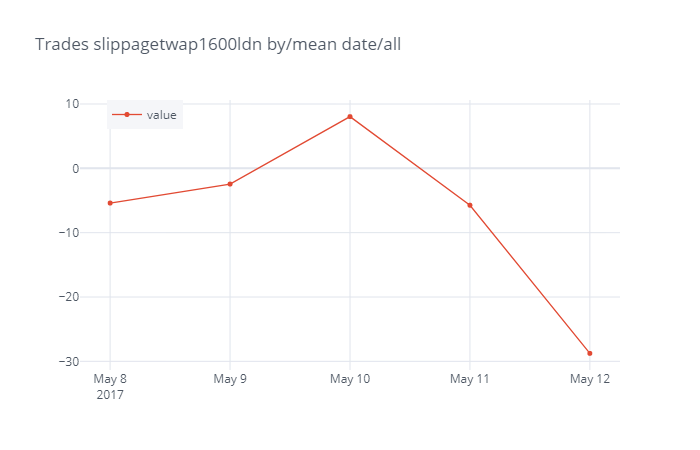

In [13]:
tca_results.timeline_charts['trade_df_slippagetwap1600LDN_by/mean_date/all']

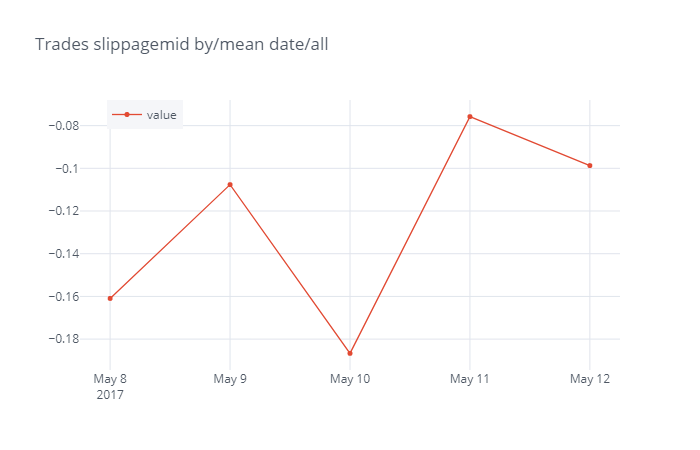

In [14]:
tca_results.timeline_charts['trade_df_slippagemid_by/mean_date/all']

We can also display the market data charts alongside our orders executed (and the benchmarks, which in our case is the arrival price, as well as the TWAP around 1600 LDN the same day.

In [15]:
tca_results.sparse_market_charts.keys()

dict_keys(['EURUSD_trade_df', 'EURUSD_order_df'])

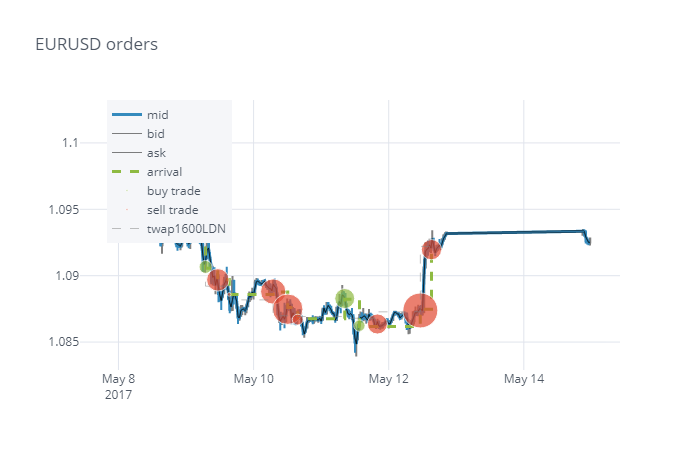

In [16]:
tca_results.sparse_market_charts['EURUSD_order_df']

## Conclusion

We have seen how to use tcapy to calculate metrics using benchmarks, which can be heavily parameterized. We hope to add more examples later.